In [1]:
!pip install tqdm
import os
import time
from tqdm import tqdm

clean_path = './train/clean/'
noisy_path = './train/noisy/'

train_data = [(noisy_path + wav, clean_path + wav) for wav in os.listdir(clean_path)]
print(len(train_data))
print(train_data[:3])

600
[('./train/noisy/fileid_0.wav', './train/clean/fileid_0.wav'), ('./train/noisy/fileid_1.wav', './train/clean/fileid_1.wav'), ('./train/noisy/fileid_10.wav', './train/clean/fileid_10.wav')]


In [2]:
!pip install scipy
import numpy as np
import torch
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from smallmodel import *
from scipy.io import wavfile as sf

In [3]:
example = sf.read(train_data[0][0])[1]
example = example / 32768.0
print(np.max(example), np.min(example))

def get_tensor(file_name):
    x = sf.read(file_name)[1]
    x = x / 32768.0
    x = torch.Tensor(x)
    return x

get_tensor(train_data[1][0]).shape

0.57244873046875 -0.532073974609375


torch.Size([480000])

In [4]:
class SmallDataset(Dataset):
    def __init__(self, data, preprocess):
        super().__init__()
        self.data = data
        self.preprocess = preprocess
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, i):
        noisy, clean = self.data[i]
        noisy, clean = self.preprocess(noisy), self.preprocess(clean)
        return noisy, clean

In [5]:
batch_size = 10
num_workers = 4

train_dataset = SmallDataset(train_data, get_tensor)
train_dataloader = DataLoader(train_dataset, num_workers=num_workers, batch_size=batch_size)

In [6]:
model = DCCRN(rnn_hidden=128, win_len=512, hop_len=128, use_clstm=False, masking_mode='R', kernel_num=(16,16,32,32,64,64), win_type='hann')
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)
print('GPU is ' + 'not '*(1 - torch.cuda.is_available()) + 'available.')

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('The number of parameters of model is', num_params)

GPU is available.
The number of parameters of model is 483437


In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = loss

sample = get_tensor(train_data[1][0]).unsqueeze(axis=0).to(device)
model(sample).shape

torch.Size([1, 480000])

In [8]:
epochs = 60
losses = []

for epoch in range(epochs):
    start = time.time()
    epoch_loss = []
    
    for noisy, clean in tqdm(train_dataloader):
        noisy = noisy.to(device)
        clean = clean.to(device)
        result = model(noisy)
        loss_fn = criterion(result, clean)
        epoch_loss.append(loss_fn.item())
        
        optimizer.zero_grad()
        loss_fn.backward()
        optimizer.step()
    
    epoch_loss = np.mean(epoch_loss)
    losses.append(epoch_loss)
    
    print(f'epoch {epoch+1}/{epochs} - loss: {epoch_loss:.4f}, time: {time.time() - start:.2f}s')

100%|██████████| 60/60 [03:00<00:00,  3.01s/it]


epoch 1/60 - loss: -6.3391, time: 180.34s


100%|██████████| 60/60 [03:00<00:00,  3.01s/it]


epoch 2/60 - loss: -13.1110, time: 180.71s


100%|██████████| 60/60 [03:00<00:00,  3.01s/it]


epoch 3/60 - loss: -15.2061, time: 180.83s


100%|██████████| 60/60 [03:00<00:00,  3.01s/it]


epoch 4/60 - loss: -16.3265, time: 180.70s


100%|██████████| 60/60 [03:01<00:00,  3.02s/it]


epoch 5/60 - loss: -16.8154, time: 181.09s


100%|██████████| 60/60 [03:00<00:00,  3.01s/it]


epoch 6/60 - loss: -16.9520, time: 180.80s


100%|██████████| 60/60 [03:00<00:00,  3.01s/it]


epoch 7/60 - loss: -17.2806, time: 180.48s


100%|██████████| 60/60 [03:00<00:00,  3.01s/it]


epoch 8/60 - loss: -17.3645, time: 180.59s


100%|██████████| 60/60 [03:00<00:00,  3.01s/it]


epoch 9/60 - loss: -18.3379, time: 180.47s


100%|██████████| 60/60 [03:00<00:00,  3.00s/it]


epoch 10/60 - loss: -18.4486, time: 180.25s


100%|██████████| 60/60 [03:00<00:00,  3.00s/it]


epoch 11/60 - loss: -18.6591, time: 180.04s


100%|██████████| 60/60 [03:00<00:00,  3.01s/it]


epoch 12/60 - loss: -18.4772, time: 180.59s


100%|██████████| 60/60 [03:00<00:00,  3.01s/it]


epoch 13/60 - loss: -18.7225, time: 180.32s


100%|██████████| 60/60 [03:00<00:00,  3.00s/it]


epoch 14/60 - loss: -18.6427, time: 180.17s


100%|██████████| 60/60 [03:00<00:00,  3.00s/it]


epoch 15/60 - loss: -18.5798, time: 180.18s


100%|██████████| 60/60 [02:59<00:00,  3.00s/it]


epoch 16/60 - loss: -18.6845, time: 180.00s


100%|██████████| 60/60 [02:59<00:00,  2.99s/it]


epoch 17/60 - loss: -18.7286, time: 179.63s


100%|██████████| 60/60 [02:59<00:00,  2.99s/it]


epoch 18/60 - loss: -19.0928, time: 179.70s


100%|██████████| 60/60 [02:59<00:00,  3.00s/it]


epoch 19/60 - loss: -19.1223, time: 179.76s


100%|██████████| 60/60 [03:00<00:00,  3.00s/it]


epoch 20/60 - loss: -19.4014, time: 180.11s


100%|██████████| 60/60 [03:00<00:00,  3.00s/it]


epoch 21/60 - loss: -19.1091, time: 180.15s


100%|██████████| 60/60 [03:00<00:00,  3.00s/it]


epoch 22/60 - loss: -19.1549, time: 180.30s


100%|██████████| 60/60 [03:00<00:00,  3.00s/it]


epoch 23/60 - loss: -19.7006, time: 180.06s


100%|██████████| 60/60 [02:59<00:00,  3.00s/it]


epoch 24/60 - loss: -19.9633, time: 179.98s


100%|██████████| 60/60 [02:59<00:00,  3.00s/it]


epoch 25/60 - loss: -19.9100, time: 179.72s


100%|██████████| 60/60 [02:59<00:00,  3.00s/it]


epoch 26/60 - loss: -20.2303, time: 179.84s


100%|██████████| 60/60 [02:59<00:00,  2.99s/it]


epoch 27/60 - loss: -19.7206, time: 179.67s


100%|██████████| 60/60 [03:00<00:00,  3.00s/it]


epoch 28/60 - loss: -19.3535, time: 180.25s


100%|██████████| 60/60 [03:00<00:00,  3.02s/it]


epoch 29/60 - loss: -19.9779, time: 180.98s


100%|██████████| 60/60 [03:00<00:00,  3.01s/it]


epoch 30/60 - loss: -20.2823, time: 180.88s


100%|██████████| 60/60 [03:00<00:00,  3.01s/it]


epoch 31/60 - loss: -20.4380, time: 180.71s


100%|██████████| 60/60 [03:00<00:00,  3.01s/it]


epoch 32/60 - loss: -20.0906, time: 180.89s


100%|██████████| 60/60 [03:01<00:00,  3.02s/it]


epoch 33/60 - loss: -20.1880, time: 181.14s


100%|██████████| 60/60 [03:01<00:00,  3.02s/it]


epoch 34/60 - loss: -20.5070, time: 181.33s


100%|██████████| 60/60 [03:01<00:00,  3.03s/it]


epoch 35/60 - loss: -20.6162, time: 181.54s


100%|██████████| 60/60 [03:01<00:00,  3.02s/it]


epoch 36/60 - loss: -20.5558, time: 181.49s


100%|██████████| 60/60 [03:01<00:00,  3.03s/it]


epoch 37/60 - loss: -20.3138, time: 181.84s


100%|██████████| 60/60 [03:01<00:00,  3.03s/it]


epoch 38/60 - loss: -20.5550, time: 181.93s


100%|██████████| 60/60 [03:01<00:00,  3.03s/it]


epoch 39/60 - loss: -20.5539, time: 181.75s


100%|██████████| 60/60 [03:01<00:00,  3.03s/it]


epoch 40/60 - loss: -20.7829, time: 181.58s


100%|██████████| 60/60 [03:01<00:00,  3.02s/it]


epoch 41/60 - loss: -21.0945, time: 181.05s


100%|██████████| 60/60 [03:01<00:00,  3.02s/it]


epoch 42/60 - loss: -21.0032, time: 181.21s


100%|██████████| 60/60 [03:01<00:00,  3.02s/it]


epoch 43/60 - loss: -20.8068, time: 181.50s


100%|██████████| 60/60 [03:01<00:00,  3.03s/it]


epoch 44/60 - loss: -20.6784, time: 181.58s


100%|██████████| 60/60 [03:01<00:00,  3.03s/it]


epoch 45/60 - loss: -20.5012, time: 181.74s


100%|██████████| 60/60 [03:01<00:00,  3.03s/it]


epoch 46/60 - loss: -20.9436, time: 181.54s


100%|██████████| 60/60 [03:00<00:00,  3.01s/it]


epoch 47/60 - loss: -21.2344, time: 180.53s


100%|██████████| 60/60 [03:00<00:00,  3.02s/it]


epoch 48/60 - loss: -21.1335, time: 180.97s


100%|██████████| 60/60 [03:01<00:00,  3.02s/it]


epoch 49/60 - loss: -21.2744, time: 181.36s


100%|██████████| 60/60 [03:00<00:00,  3.01s/it]


epoch 50/60 - loss: -21.0673, time: 180.86s


100%|██████████| 60/60 [03:01<00:00,  3.02s/it]


epoch 51/60 - loss: -21.2820, time: 181.15s


100%|██████████| 60/60 [03:00<00:00,  3.01s/it]


epoch 52/60 - loss: -21.4920, time: 180.66s


100%|██████████| 60/60 [03:01<00:00,  3.02s/it]


epoch 53/60 - loss: -21.4978, time: 181.09s


100%|██████████| 60/60 [03:00<00:00,  3.01s/it]


epoch 54/60 - loss: -21.4334, time: 180.88s


100%|██████████| 60/60 [03:00<00:00,  3.01s/it]


epoch 55/60 - loss: -21.2483, time: 180.81s


100%|██████████| 60/60 [03:00<00:00,  3.00s/it]


epoch 56/60 - loss: -21.6583, time: 180.03s


100%|██████████| 60/60 [03:00<00:00,  3.00s/it]


epoch 57/60 - loss: -21.7061, time: 180.26s


100%|██████████| 60/60 [03:00<00:00,  3.00s/it]


epoch 58/60 - loss: -21.7145, time: 180.16s


100%|██████████| 60/60 [03:00<00:00,  3.01s/it]


epoch 59/60 - loss: -21.6457, time: 180.34s


100%|██████████| 60/60 [03:00<00:00,  3.01s/it]

epoch 60/60 - loss: -21.6626, time: 180.62s


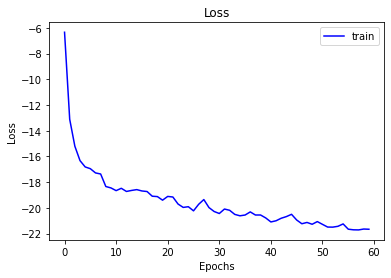

In [11]:
import matplotlib.pyplot as plt

plt.title("Loss")
plt.plot(np.arange(epochs), losses, color = 'blue', label = 'train')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

In [10]:
torch.save(model.state_dict(), "DCCRN-5h.pth")